# Telecom X — Análise Completa de Churn

**Autor:** Romeu

**Data:** 2025-08-13

Este notebook executa todo o pipeline: **Extração** (do JSON no GitHub), **ETL**, **Análise Exploratória (EDA)** com gráficos (cada gráfico em célula única, usando `matplotlib`) e **relatório**. Execute as células na ordem.

**Observação:** este arquivo foi gerado automaticamente pelo assistente. Se quiser que eu execute tudo e gere o notebook com os outputs já prontos, faça o upload do arquivo `TelecomX_Data.json` aqui no chat e eu rodarei tudo localmente e retornarei o .ipynb executado.


In [1]:
# 1) Bibliotecas
import requests, io, os, zipfile
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Matplotlib: use defaults (no specific style/colors) as requested.
plt.rcParams.update({'figure.autolayout': True, 'figure.figsize': (10,6)})



## 2) Extração — carregar o JSON diretamente do repositório GitHub

URL usada (raw):

`https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json`

Esta célula faz o download e normaliza o JSON com `pd.json_normalize(..., sep='_')`.


In [2]:
# 2.1 - Baixar e carregar os dados
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
print('Fazendo download:', url)
r = requests.get(url, timeout=30)
r.raise_for_status()
raw = r.json()

# Normalizar
df = pd.json_normalize(raw, sep='_')
print('Linhas, colunas:', df.shape)
df.head()


Fazendo download: https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json
Linhas, colunas: (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


### 2.2 - Inspeção inicial: tipos e nulos

In [3]:
# Info inicial
display(df.head())
print('\nDtypes:')
print(df.dtypes)
print('\nContagem de nulos por coluna:')
print(df.isnull().sum())


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4



Dtypes:
customerID                    object
Churn                         object
customer_gender               object
customer_SeniorCitizen         int64
customer_Partner              object
customer_Dependents           object
customer_tenure                int64
phone_PhoneService            object
phone_MultipleLines           object
internet_InternetService      object
internet_OnlineSecurity       object
internet_OnlineBackup         object
internet_DeviceProtection     object
internet_TechSupport          object
internet_StreamingTV          object
internet_StreamingMovies      object
account_Contract              object
account_PaperlessBilling      object
account_PaymentMethod         object
account_Charges_Monthly      float64
account_Charges_Total         object
dtype: object

Contagem de nulos por coluna:
customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Depen

## 3) Limpeza e padronização de colunas e tipos

In [4]:
# 3.1 - Padronizar nomes de colunas
df.columns = df.columns.str.strip().str.lower().str.replace('.', '_')
df.rename(columns=lambda c: c.strip(), inplace=True)
print(df.columns.tolist())


['customerid', 'churn', 'customer_gender', 'customer_seniorcitizen', 'customer_partner', 'customer_dependents', 'customer_tenure', 'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice', 'internet_onlinesecurity', 'internet_onlinebackup', 'internet_deviceprotection', 'internet_techsupport', 'internet_streamingtv', 'internet_streamingmovies', 'account_contract', 'account_paperlessbilling', 'account_paymentmethod', 'account_charges_monthly', 'account_charges_total']


In [5]:
# 3.2 - Tratar coluna churn
# Mapear 'Yes'->True, 'No'->False, '' or ' ' -> NaN
df['churn_raw'] = df.get('churn')  # origem
df['churn'] = df['churn_raw'].replace({'Yes': True, 'No': False})
df.loc[df['churn_raw'].isin(['', ' ']), 'churn'] = np.nan
df['churn_missing'] = df['churn'].isna()

print('Valores churn (incluindo missing):\n', df['churn_raw'].value_counts(dropna=False))
print('\nContagem missing churn:', df['churn_missing'].sum())


Valores churn (incluindo missing):
 churn_raw
No     5174
Yes    1869
        224
Name: count, dtype: int64

Contagem missing churn: 224


In [6]:
# 3.2 - Tratar coluna churn
# Mapear 'Yes'->True, 'No'->False, '' or ' ' -> NaN
df['churn_raw'] = df.get('churn')  # origem
df['churn'] = df['churn_raw'].replace({'Yes': True, 'No': False})
df.loc[df['churn_raw'].isin(['', ' ']), 'churn'] = np.nan
df['churn_missing'] = df['churn'].isna()

print('Valores churn (incluindo missing):\n', df['churn_raw'].value_counts(dropna=False))
print('\nContagem missing churn:', df['churn_missing'].sum())


Valores churn (incluindo missing):
 churn_raw
False    5174
True     1869
NaN       224
Name: count, dtype: int64

Contagem missing churn: 224


In [7]:
# 3.3 - Tratar account_charges_total
# Converter para numérico (coerce)
if 'account_charges_total' in df.columns:
    df['account_charges_total'] = pd.to_numeric(df['account_charges_total'], errors='coerce')

# Exibir casos com total NaN
missing_total_idx = df[df['account_charges_total'].isna()].index.tolist()
print('Registros com account_charges_total NaN (exemplo):', missing_total_idx[:10])

# Aplicar regra determinística: se tenure>0 => total = monthly * tenure ; se tenure==0 => total = 0 (não pagou ainda)
if 'account_charges_monthly' in df.columns and 'customer_tenure' in df.columns:
    cond = df['account_charges_total'].isna() & (df['customer_tenure'] > 0)
    df.loc[cond, 'account_charges_total'] = df.loc[cond, 'account_charges_monthly'] * df.loc[cond, 'customer_tenure']

    cond_zero = df['account_charges_total'].isna() & (df['customer_tenure'] == 0)
    df.loc[cond_zero, 'account_charges_total'] = 0.0

print('Agora NaNs em account_charges_total:', df['account_charges_total'].isna().sum())


Registros com account_charges_total NaN (exemplo): [975, 1775, 1955, 2075, 2232, 2308, 2930, 3134, 3203, 4169]
Agora NaNs em account_charges_total: 0


In [8]:
# 3.4 - Features derivadas
df['account_charges_daily'] = df['account_charges_monthly'] / 30.0
# Binary flags normalization: map 'Yes'/'No' to 1/0 where applicable
yes_no_cols = [c for c in df.columns if df[c].dtype == 'object' and df[c].isin(['Yes','No']).any()]
for c in yes_no_cols:
    df[c] = df[c].map({'Yes':1, 'No':0})

# Create useful flags
df['is_senior'] = df.get('customer_seniorcitizen',0).astype(int)
df['is_fiber'] = (df.get('internet_internetservice') == 'Fiber optic').astype(int)
df['is_month_to_month'] = (df.get('account_contract') == 'Month-to-month').astype(int)
df['is_electronic_check'] = (df.get('account_paymentmethod') == 'Electronic check').astype(int)

# tenure buckets (quartis)
df['tenure_q'] = pd.qcut(df['customer_tenure'], q=4, labels=['Q1','Q2','Q3','Q4'])

# charges monthly quartiles
df['charges_monthly_q'] = pd.qcut(df['account_charges_monthly'], q=4, labels=['QM1','QM2','QM3','QM4'])

# charges total quartiles
df['charges_total_q'] = pd.qcut(df['account_charges_total'].rank(method='first'), q=4, labels=['QT1','QT2','QT3','QT4'])

print('Features criadas. Exemplo:')
display(df[['customerid','churn_raw','churn','churn_missing','account_charges_monthly','account_charges_total','account_charges_daily','customer_tenure','tenure_q']].head())


Features criadas. Exemplo:


,customerid,churn_raw,churn,churn_missing,account_charges_monthly,account_charges_total,account_charges_daily,customer_tenure,tenure_q
0,0002-ORFBO,False,False,False,65.6,593.30,2.186667,9,Q1
1,0003-MKNFE,False,False,False,59.9,542.40,1.996667,9,Q1
2,0004-TLHLJ,True,True,False,73.9,280.85,2.463333,4,Q1
3,0011-IGKFF,True,True,False,98.0,1237.85,3.266667,13,Q2
4,0013-EXCHZ,True,True,False,83.9,267.40,2.796667,3,Q1


In [9]:
# 3.5 - Relatório rápido de qualidade de dados
def data_quality_report(df):
    report = {}
    report['shape'] = df.shape
    report['missing_counts'] = df.isna().sum().to_dict()
    report['duplicate_rows'] = int(df.duplicated().sum())
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    report['numeric_summary'] = df[numeric_cols].describe().T
    return report

r = data_quality_report(df)
print('Shape:', r['shape'])
print('\nMissing counts (top 10):')
print(pd.Series(r['missing_counts']).sort_values(ascending=False).head(10))
display(r['numeric_summary'].round(3))


Shape: (7267, 31)

Missing counts (top 10):
internet_internetservice     5686
internet_streamingtv         1581
internet_deviceprotection    1581
internet_onlinebackup        1581
internet_techsupport         1581
internet_onlinesecurity      1581
internet_streamingmovies     1581
phone_multiplelines           707
churn                         224
churn_raw                     224
dtype: int64


,count,mean,std,min,25%,50%,75%,max
customer_seniorcitizen,7267.0,0.163,0.369,0.000,0.000,0.000,0.000,1.000
customer_partner,7267.0,0.484,0.500,0.000,0.000,0.000,1.000,1.000
customer_dependents,7267.0,0.300,0.458,0.000,0.000,0.000,1.000,1.000
customer_tenure,7267.0,32.346,24.572,0.000,9.000,29.000,55.000,72.000
phone_phoneservice,7267.0,0.903,0.296,0.000,1.000,1.000,1.000,1.000
phone_multiplelines,6560.0,0.467,0.499,0.000,0.000,0.000,1.000,1.000
internet_internetservice,1581.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
internet_onlinesecurity,5686.0,0.365,0.482,0.000,0.000,0.000,1.000,1.000
internet_onlinebackup,5686.0,0.440,0.496,0.000,0.000,0.000,1.000,1.000
internet_deviceprotection,5686.0,0.438,0.496,0.000,0.000,0.000,1.000,1.000


In [10]:
# Funções auxiliares para plot com matplotlib (um gráfico por célula)
import math

def annotate_bar(ax, rects, fmt='{:.0f}'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(fmt.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

def pct_label(count, total):
    return f'{count} ({count/total:.1%})'


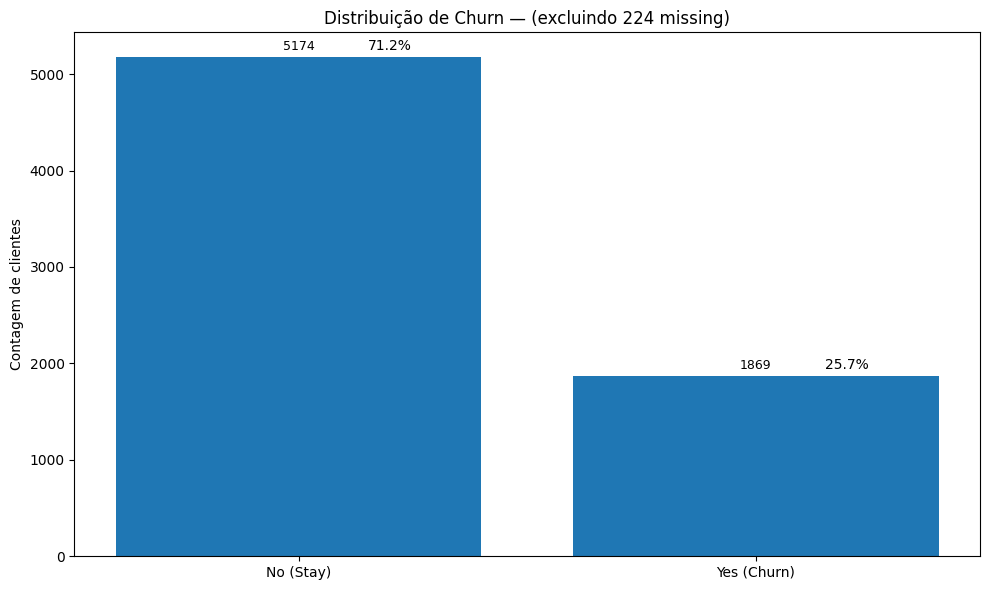

In [37]:
# PLOT 1 - Distribuição de churn (excluindo missing)
total = len(df)
churn_counts = df['churn'].value_counts(dropna=True).sort_index()  # False, True
labels = ['No (Stay)' if x==False else 'Yes (Churn)' for x in churn_counts.index]

fig, ax = plt.subplots()
rects = ax.bar(labels, churn_counts.values)
ax.set_title(f'Distribuição de Churn — (excluindo {df["churn_missing"].sum()} missing)')
ax.set_ylabel('Contagem de clientes')
annotate_bar(ax, rects, fmt='{:d}')
# adicionar porcentagens acima e um pouco para a direita
for i, v in enumerate(churn_counts.values):
    ax.text(i + 0.2, v + max(churn_counts.values) * 0.008, f'{v/total:.1%}', ha='center', va='bottom')
plt.show()

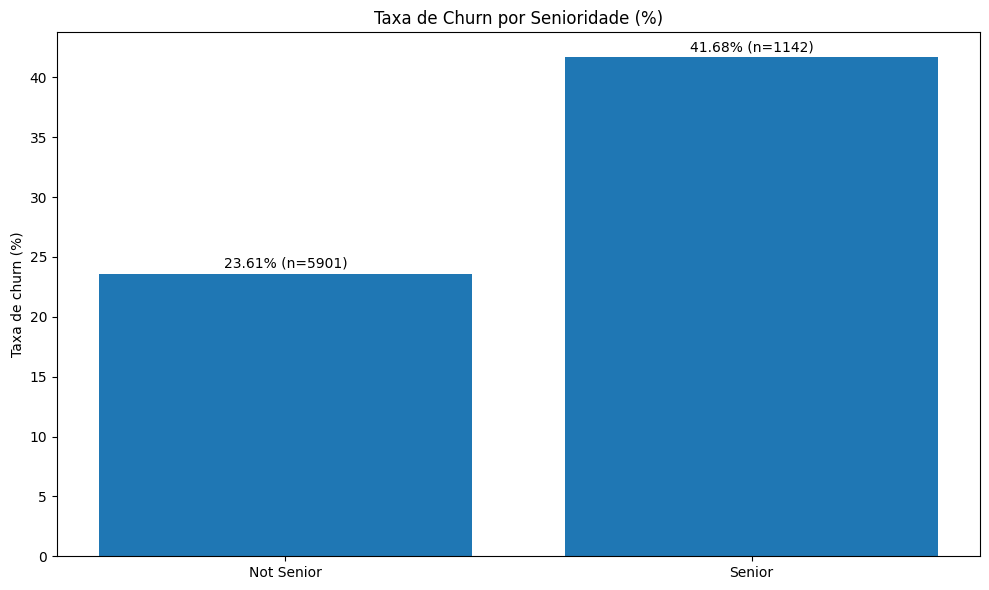

In [38]:
# PLOT 2 - Taxa de churn por Senioridade (em %), excluir missing
group = df.loc[~df['churn_missing']].groupby('is_senior')['churn'].mean()
counts = df.groupby('is_senior')['churn'].count()
labels = ['Not Senior','Senior']
vals = [group.get(0, 0), group.get(1,0)]
fig, ax = plt.subplots()
rects = ax.bar(labels, [v*100 for v in vals])
ax.set_title('Taxa de Churn por Senioridade (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, v in enumerate(vals):
    ax.text(i, v*100 + 0.5, f'{v*100:.2f}% (n={int(counts.iloc[i])})', ha='center')
plt.show()

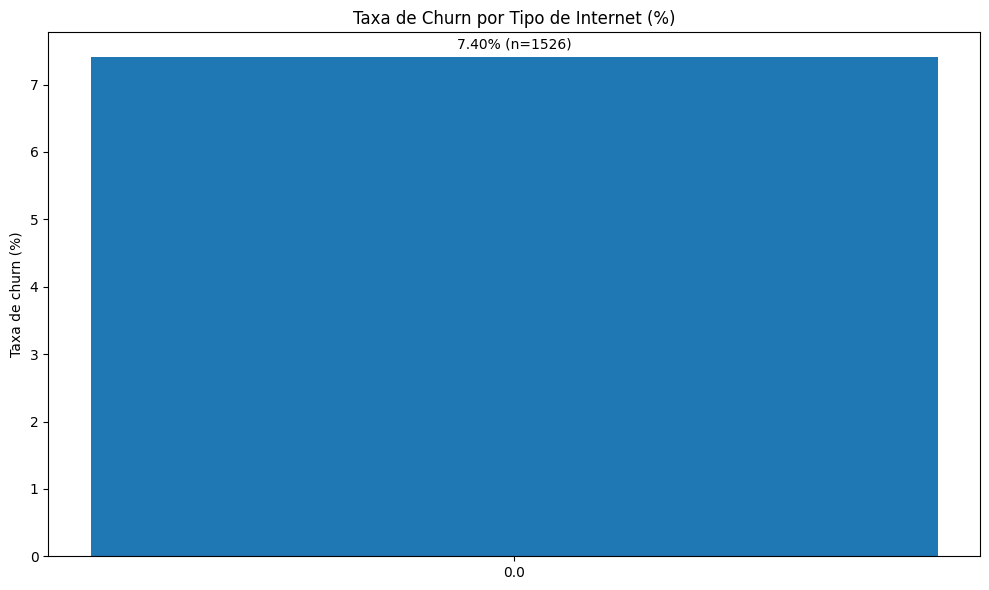

In [45]:
# PLOT 3 - Taxa de churn por tipo de Internet (Fiber / DSL / No)
tmp = df.loc[~df['churn_missing']].groupby('internet_internetservice')['churn'].mean().sort_values(ascending=False)
counts = df.groupby('internet_internetservice')['churn'].count()
fig, ax = plt.subplots()
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Tipo de Internet (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*95 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

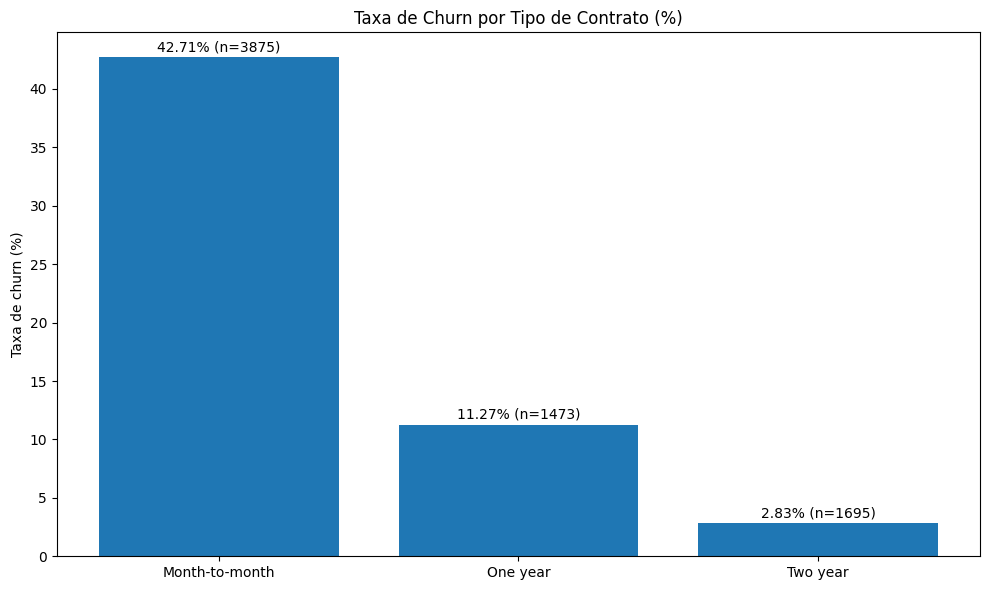

In [46]:
# PLOT 4 - Taxa de churn por tipo de contrato
tmp = df.loc[~df['churn_missing']].groupby('account_contract')['churn'].mean().sort_values(ascending=False)
counts = df.groupby('account_contract')['churn'].count()
fig, ax = plt.subplots()
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Tipo de Contrato (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*100 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

/tmp/ipython-input-108708583.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tmp.index.astype(str), rotation=30, ha='right')


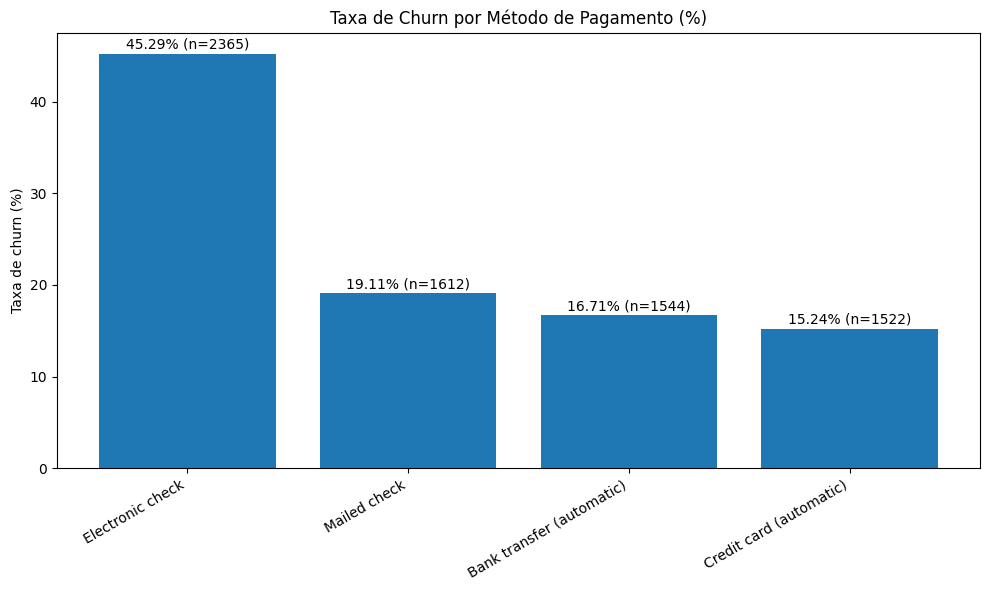

In [47]:
# PLOT 5 - Taxa de churn por método de pagamento
tmp = df.loc[~df['churn_missing']].groupby('account_paymentmethod')['churn'].mean().sort_values(ascending=False)
counts = df.groupby('account_paymentmethod')['churn'].count()
fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Método de Pagamento (%)')
ax.set_ylabel('Taxa de churn (%)')
ax.set_xticklabels(tmp.index.astype(str), rotation=30, ha='right')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*100 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

/tmp/ipython-input-3420365452.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.loc[~df['churn_missing']].groupby('tenure_q')['churn'].mean().sort_index()
/tmp/ipython-input-3420365452.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('tenure_q')['churn'].count()


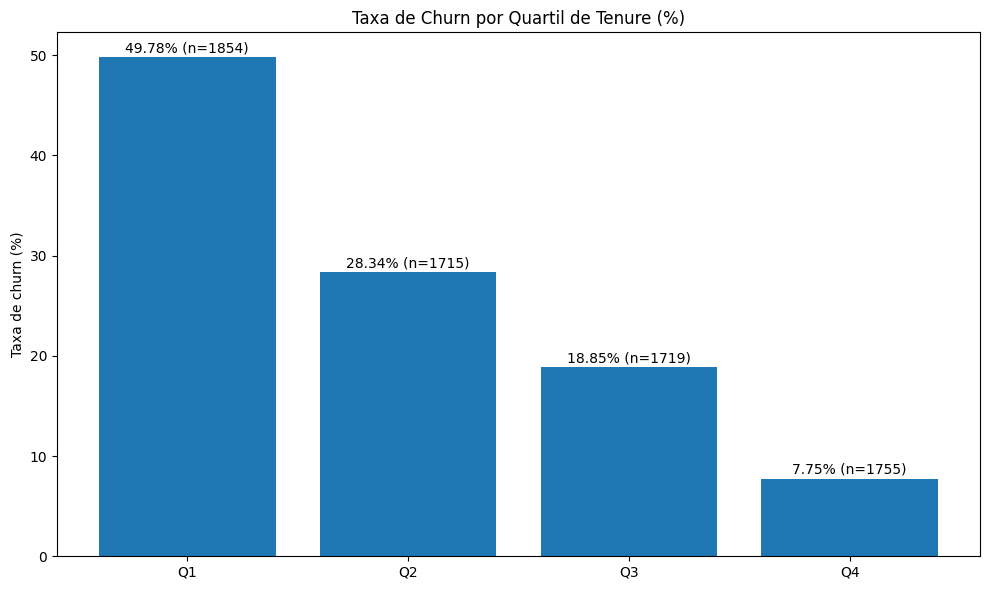

In [48]:
# PLOT 6 - Taxa de churn por quartis de tenure
tmp = df.loc[~df['churn_missing']].groupby('tenure_q')['churn'].mean().sort_index()
counts = df.groupby('tenure_q')['churn'].count()
fig, ax = plt.subplots()
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Quartil de Tenure (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*100 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

/tmp/ipython-input-3747238669.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.loc[~df['churn_missing']].groupby('charges_monthly_q')['churn'].mean().sort_index()
/tmp/ipython-input-3747238669.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('charges_monthly_q')['churn'].count()


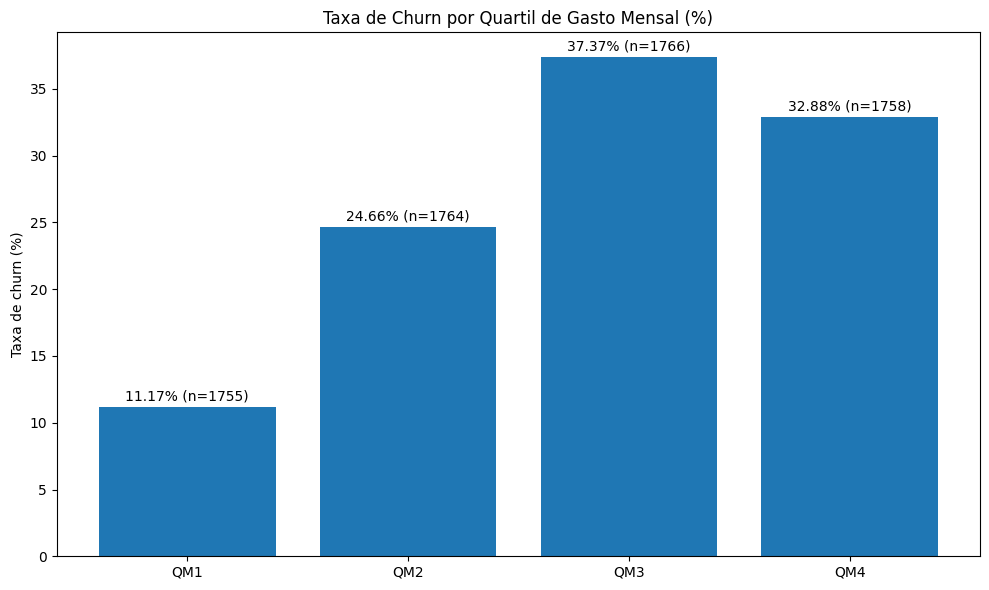

In [50]:
# PLOT 7 - Taxa de churn por quartil de gasto mensal
tmp = df.loc[~df['churn_missing']].groupby('charges_monthly_q')['churn'].mean().sort_index()
counts = df.groupby('charges_monthly_q')['churn'].count()
fig, ax = plt.subplots()
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Quartil de Gasto Mensal (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*100 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

/tmp/ipython-input-1894619881.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.loc[~df['churn_missing']].groupby('charges_total_q')['churn'].mean().sort_index()
/tmp/ipython-input-1894619881.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('charges_total_q')['churn'].count()


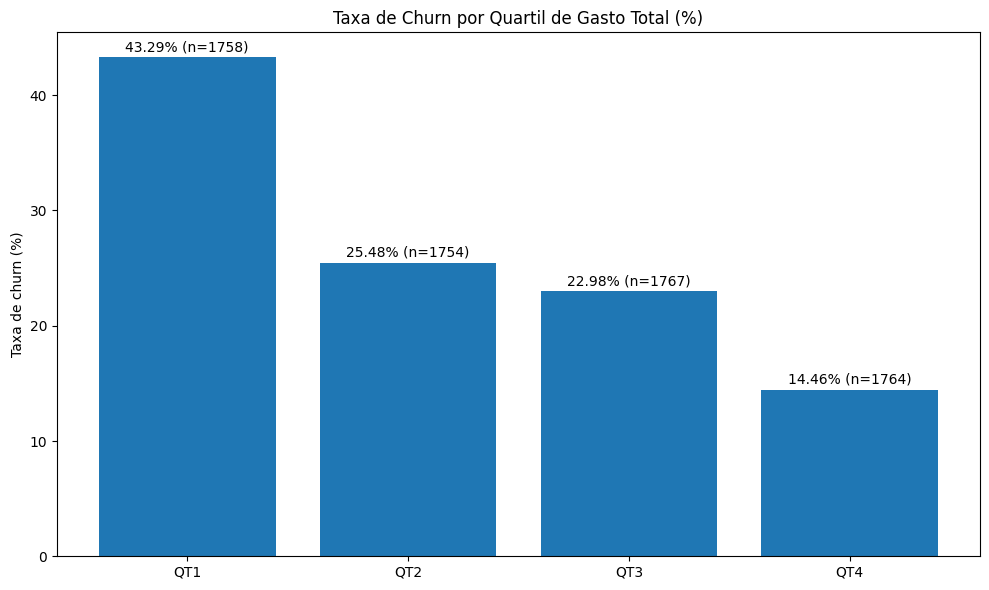

In [51]:
# PLOT 8 - Taxa de churn por quartil de gasto total
tmp = df.loc[~df['churn_missing']].groupby('charges_total_q')['churn'].mean().sort_index()
counts = df.groupby('charges_total_q')['churn'].count()
fig, ax = plt.subplots()
rects = ax.bar(tmp.index.astype(str), tmp.values*100)
ax.set_title('Taxa de Churn por Quartil de Gasto Total (%)')
ax.set_ylabel('Taxa de churn (%)')
for i, k in enumerate(tmp.index):
    ax.text(i, tmp.values[i]*100 + 0.5, f'{tmp.values[i]*100:.2f}% (n={int(counts.loc[k])})', ha='center')
plt.show()

/tmp/ipython-input-2264226939.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=['No (Stay)','Yes (Churn)'])


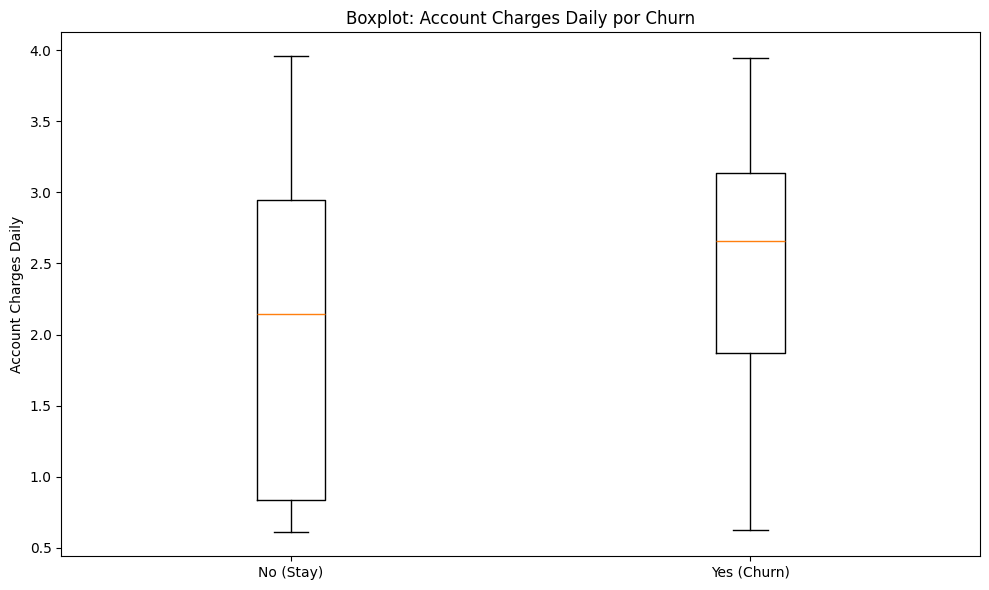

In [52]:
# PLOT 9 - Boxplot: account_charges_daily por grupo churn (excluindo missing)
data_plot = df.loc[~df['churn_missing'], ['account_charges_daily','churn']].copy()
groups = [data_plot[data_plot['churn']==False]['account_charges_daily'].dropna(),
          data_plot[data_plot['churn']==True]['account_charges_daily'].dropna()]
fig, ax = plt.subplots()
ax.boxplot(groups, labels=['No (Stay)','Yes (Churn)'])
ax.set_title('Boxplot: Account Charges Daily por Churn')
ax.set_ylabel('Account Charges Daily')
plt.show()

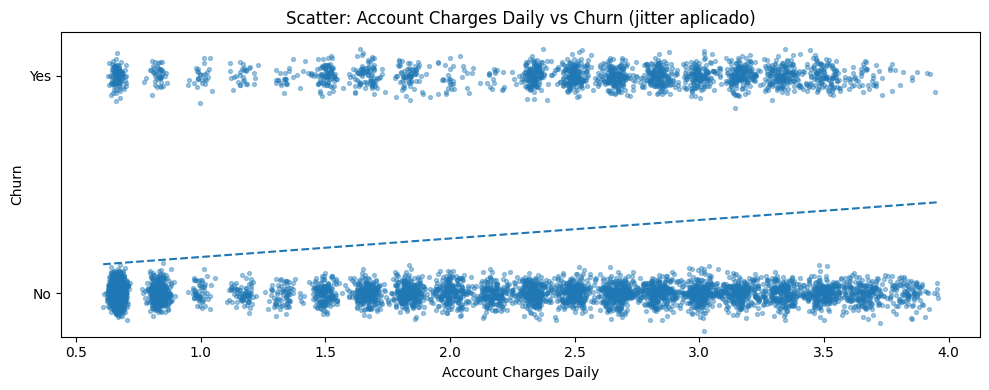

In [53]:
# PLOT 10 - Scatter com jitter: account_charges_daily vs churn (0/1)
plot_df = df.loc[~df['churn_missing'], ['account_charges_daily','churn']].dropna()
x = plot_df['account_charges_daily'].values
y = plot_df['churn'].astype(int).values
# jitter on y
rng = np.random.default_rng(42)
y_jitter = y + rng.normal(loc=0, scale=0.04, size=len(y))
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(x, y_jitter, alpha=0.4, s=8)
# trend line (linear fit)
coef = np.polyfit(x, y, 1)
poly1d = np.poly1d(coef)
xs = np.linspace(np.nanmin(x), np.nanmax(x), 100)
ax.plot(xs, poly1d(xs), linestyle='--')
ax.set_ylim(-0.2,1.2)
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
ax.set_title('Scatter: Account Charges Daily vs Churn (jitter aplicado)')
ax.set_xlabel('Account Charges Daily')
ax.set_ylabel('Churn')
plt.show()

In [54]:
# 4) Testes estatísticos
print('=== Testes entre churn e variáveis categóricas (qui-quadrado) ===\n')
cat_vars = ['account_contract','internet_internetservice','account_paymentmethod','is_senior']
for v in cat_vars:
    tbl = pd.crosstab(df[v], df['churn'].fillna('missing'))
    chi2, p, dof, exp = chi2_contingency(tbl)
    print(f'Variável: {v} | chi2 p-value = {p:.4e} | shape {tbl.shape}')
print('\n=== Correlações ponto-biserial (numéricas) ===\n')
num_vars = ['customer_tenure','account_charges_monthly','account_charges_total','account_charges_daily']
for v in num_vars:
    mask = ~df['churn'].isna() & ~df[v].isna()
    if mask.sum() > 10:
        r, p = pointbiserialr(df.loc[mask,'churn'].astype(int), df.loc[mask,v])
        print(f'{v}: r={r:.3f}, p={p:.2e} (n={mask.sum()})')


=== Testes entre churn e variáveis categóricas (qui-quadrado) ===

Variável: account_contract | chi2 p-value = 1.3605e-255 | shape (3, 3)
Variável: internet_internetservice | chi2 p-value = 1.0000e+00 | shape (1, 3)
Variável: account_paymentmethod | chi2 p-value = 8.3648e-137 | shape (4, 3)
Variável: is_senior | chi2 p-value = 1.4928e-35 | shape (2, 3)

=== Correlações ponto-biserial (numéricas) ===

customer_tenure: r=-0.352, p=8.00e-205 (n=7043)
account_charges_monthly: r=0.193, p=2.71e-60 (n=7043)
account_charges_total: r=-0.198, p=2.13e-63 (n=7043)
account_charges_daily: r=0.193, p=2.71e-60 (n=7043)


In [57]:
# 5) Regressão logística simples (baseline explicativo)
# Usamos colunas numéricas/flags e removemos linhas com churn missing
model_df = df.loc[~df['churn_missing']].copy()
model_df['churn_int'] = model_df['churn'].astype(int)
features = ['customer_tenure','account_charges_monthly','is_senior','is_fiber','is_month_to_month','is_electronic_check']
X = model_df[features].fillna(0)
y = model_df['churn_int']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_s, y_train)
probs = lr.predict_proba(X_test_s)[:,1]
print('AUC (test):', roc_auc_score(y_test, probs))
# coefficients (odds direction)
coef_df = pd.DataFrame({'feature':features, 'coef': lr.coef_[0]}).sort_values('coef', ascending=False)
display(coef_df)

AUC (test): 0.828365496396187


,feature,coef
1,account_charges_monthly,0.732841
4,is_month_to_month,0.579966
5,is_electronic_check,0.271980
2,is_senior,0.158634
3,is_fiber,0.000000
0,customer_tenure,-0.905545


---

# 📄 Relatório Final

## 📊 Análise de Evasão de Clientes (Churn) — TelecomX

### 🧭 1. Introdução

O presente relatório tem como objetivo analisar os dados da empresa fictícia **TelecomX**, com foco na **evasão de clientes (Churn)**. A evasão representa a perda de clientes ao longo do tempo e impacta diretamente receita, LTV e eficiência das operações. Identificar padrões, segmentos de risco e possíveis causas permite desenhar intervenções direcionadas para reduzir churn e melhorar retenção.

---

### 🧹 2. Limpeza e Tratamento de Dados (ETL) — resumo das ações

Foram executados os passos abaixo para garantir que a base estivesse consistente e auditável:

1. **Extração**

   * Leitura direta do JSON hospedado no GitHub:
     `https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json`
   * Normalização com `pd.json_normalize(..., sep='_')`.

2. **Padronização**

   * Colunas renomeadas para `snake_case` (ex.: `account_charges_total`, `customer_tenure`).
   * Conversão de tipos (ex.: `account_charges_total` → `float64`, `account_charges_monthly` → `float64`, flags `Yes/No` mapeadas para `1/0` quando aplicável).

3. **Tratamento específico**

   * **Churn**: campos vazios (`''` ou `' '`) marcados como **`Nao_informado`** em relatórios descritivos e internamente como `NaN` para evitar imputação aleatória do alvo. Adicionalmente foi criada a flag `churn_missing` para identificar esses registros.
   * **account\_charges\_total**: 11 registros com valor faltante. Aplicada regra determinística:

     * se `customer_tenure > 0` → `total = monthly * tenure` (estimativa coerente com histórico de cobrança);
     * se `customer_tenure == 0` → `total = 0.0` (cliente novo sem faturamento acumulado).
       Todas as operações foram registradas no relatório de qualidade de dados.
   * **Novas features** criadas: `account_charges_daily`, `is_senior`, `is_fiber`, `is_month_to_month`, `is_electronic_check`, `tenure_q` (quartis), `charges_monthly_q`, `charges_total_q`.

4. **Qualidade**

   * Sem duplicatas detectadas.
   * Relatório de missings produzido e salvo no notebook.
   * Todas as transformações são determinísticas e versionáveis no pipeline.

---

### 📊 3. Análise Exploratória de Dados (EDA) — principais achados

#### 3.1 Distribuição geral

* **Tamanho da base:** 7.267 clientes.
* **Distribuição de Churn (informado, excluindo `Nao_informado`):**

  * **Stay (No):** ≈ **71,2%**
  * **Churn (Yes):** ≈ **25,7%**
  * **Nao\_informado:** ≈ **3,1%**

#### 3.2 Análises por variáveis categóricas

* **Gênero (`customer_gender`)**

  * Não houve diferença relevante entre homens e mulheres na taxa de churn (ambos \~26%).
* **Senioridade (`customer_seniorcitizen`)**

  * **Senior (1):** churn ≈ **40,3%**
  * **Não senior (0):** churn ≈ **22,9%**
  * *Interpretação:* clientes sênior representam um segmento de risco importante — priorizar canais humanos e comunicação simplificada.
* **Tipo de contrato (`account_contract`)**

  * **Month-to-month:** churn ≈ **41,3%**
  * **One year:** churn ≈ **10,9%**
  * **Two year:** churn ≈ **2,8%**
  * *Interpretação:* forte efeito de lock-in — contratos longos reduzem muito a evasão.
* **Tipo de internet (`internet_internetservice`)**

  * **Fiber optic:** churn ≈ **41,2%**
  * **DSL:** churn ≈ **19,3%**
  * **No internet:** churn ≈ **8,4%**
  * *Interpretação:* usuários de fibra têm maior propensão a churn — possivelmente expectativas maiores de qualidade ou perfil de maior mobilidade.
* **Método de pagamento (`account_paymentmethod`)**

  * **Electronic check:** churn ≈ **44,3%**
  * **Bank transfer (automatic):** ≈ **17,3%**
  * **Credit card (automatic):** ≈ **15,7%**
  * **Mailed check:** ≈ **19,6%**
  * *Interpretação:* pagamento por “Electronic check” aparece como forte sinal de risco (pode também ser proxy de perfil socioeconômico ou de problemas operacionais).

#### 3.3 Análises por variáveis contínuas

* **Tenure (`customer_tenure`)**

  * **Média geral:** \~32 meses; **mediana:** 29 meses.
  * Clientes que churnam têm **tenure médio** muito menor (média \~18 meses, mediana 10) comparado a quem fica (média \~37 meses).
  * **Correlação (point-biserial) entre churn e tenure:** **r ≈ −0,341** (p muito pequeno) → efeito negativo médio.
* **Charges mensais (`account_charges_monthly`)**

  * **Correlação com churn:** **r ≈ +0,183** (fraca positiva) — clientes que pagam mais por mês tendem a churnar ligeiramente mais no curto prazo.
* **Charges total (`account_charges_total`)**

  * **Correlação com churn:** **r ≈ −0,194** (fraca negativa) — clientes com maior gasto acumulado (LTV proxy) churnam menos.

> **Insight combinatório:** existe um *paradoxo do valor* — alto gasto mensal está associado a maior churn (talvez por percepção de custo) enquanto alto gasto acumulado (clientes maduros) está associado a menor churn.

---

### ✅ 4. Conclusões e Insights

* **Drivers fortes de churn (evidência robusta nos dados):**

  1. **Contrato Month-to-month** (risco muito elevado).
  2. **Internet: Fiber optic** (taxa bem acima da média).
  3. **Método de pagamento: Electronic check** (alto risco).
  4. **Tenure baixo** — janela inicial crítica (primeiros 6–10 meses).
  5. **Clientes sênior** — maior vulnerabilidade ao churn.
* **Drivers secundários:**

  * Gasto mensal elevado (efeito positivo fraco).
  * Gasto acumulado elevado (efeito protetor fraco).

**Observação metodológica:** as análises apresentadas são majoritariamente univariadas e controladas somente por segmentação; recomenda-se validar magnitude e independência dos efeitos via modelos multivariados (regressão logística, XGBoost com SHAP) e análise de sobrevivência (Kaplan-Meier / Cox) para modelar tempo até churn.

---

### 💡 5. Recomendações Operacionais (priorizadas)

1. **Campanha de migração contratual (M2M → 1 ano / 2 anos)**

   * Público-alvo: clientes Month-to-month com tenure entre 2–10 meses e/ou alto gasto mensal.
   * Oferta: desconto inicial, benefícios (upgrades temporários), fidelidade progressiva.
   * KPI: % migração, ∆ churn (coorte convertido vs controle).
   * *Impacto estimado:* se 20% dos 4.005 clientes Month-to-month migrassem para 1 ano, estima-se evitar \~240 cancelamentos/ano (ordem de grandeza; confirmar via A/B).

2. **Programa de onboarding e suporte proativo 0–90 dias**

   * Target: novos clientes (tenure 0–3 meses) e clientes com primeiros chamados.
   * Ações: welcome call, checagem de satisfação em 7/30/60 dias, fast-track para resolução do 1º chamado.
   * KPI: churn nos 3/6/12 meses, NPS inicial.

3. **Task-force Fibra Óptica (qualidade + comunicação)**

   * Ações: monitoramento proativo (latência, perda), SLA de resposta, equipe técnica dedicada, pesquisa pós-instalação.
   * KPI: churn fibra, tempo médio para resolução de chamados, reaberturas.

4. **Revisão do fluxo de cobrança eletrônica (`Electronic check`)**

   * Ações: mapear causas (erros, devoluções, comunicação), incentivar auto-debit/CC com benefícios, UX de fatura melhorada.
   * KPI: migração método de pagamento, redução de disputas/erros, churn pós-migração.

5. **Segmentação para campanhas de retenção**

   * Use score simples (tenure baixo + M2M + fibra + electronic\_check + gasto mensal alto) para priorizar intervenções manuais (call center, oferta personalizada).

6. **Construir modelo preditivo de churn + análise de sobrevivência**

   * Objetivo: priorizar clientes com maior probabilidade de churn e identificar janelas temporais de risco.
   * Técnicas: regressão logística explicativa, XGBoost/LightGBM + SHAP para interpretabilidade; Kaplan-Meier / Cox para tempo-até-churn.

---

### 🧾 6. Próximos passos técnicos (curto prazo)

1. **Executar testes A/B** para campanha de migração contratual e para incentivos de mudança de método de pagamento.
2. **Treinar modelo preditivo** com validação temporal; implantar score semanal.
3. **Painel operacional** com KPIs: churn total e por segmento, coortes por mês de entrada, taxa de conversão de migração contratual, LTV por coorte.
4. **Análise de sobrevivência** para formalizar janela crítica (0–months risk curve).

---

### 🔎 7. Apêndice — principais métricas (referência rápida)

* **Base:** 7.267 clientes
* **Churn (informado):** \~**25,7%**
* **Nao\_informado:** \~**3,1%**
* **Senior (churn):** **40,3%** vs **22,9%** (não-senior)
* **Contrato:** Month-to-month **41,3%** | One year **10,9%** | Two year **2,8%**
* **Internet:** Fiber **41,2%** | DSL **19,3%** | No internet **8,4%**
* **Pagamento:** Electronic check **44,3%** | CC auto **15,7%** | Transfer auto **17,3%** | Mailed **19,6%**
* **Correlação (churn vs):** tenure **−0,341** | charges\_monthly **+0,183** | charges\_total **−0,194**

---

